In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os

from src.utils.config import RESNET34_FULL,RESNET18_FULL,BEETLE_DATASET, Config
from src.models import download_model, load_model_weights_and_metrics, GenModel
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{amsmath}']  # for \text command


C:\Users\Jacki\AppData\Local\Temp/ipykernel_1376/3284439417.py:10: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  mpl.rcParams['text.latex.preamble'] = [


In [2]:
model_config = RESNET34_FULL
model_18_config = RESNET18_FULL
dataset_config =BEETLE_DATASET

config = Config()

model = download_model(model_config, dataset_config)
_, _, _, _ = load_model_weights_and_metrics(model, model_config)

model_18 = download_model(model_18_config, dataset_config)
_, _, _, _ = load_model_weights_and_metrics(model_18, model_18_config)

gen = GenModel(100)


In [3]:
gen_weights = 'output/GANs/Gen_01'
gen.net_G.load_state_dict(torch.load(gen_weights))

<All keys matched successfully>

In [4]:
def gauss(x, mean, std):
    exp = (x- mean)**2 / (2*std**2)
    return torch.exp(-exp)
    

In [5]:
def gen_input(start, end, step_size, std=0.25):
    r = int(end-start)
    l = int(r/step_size) - int(1/step_size) + 1
    ret = torch.zeros((  l, r))
    for i in range(l):
        x = torch.linspace(start, end-1, r)
        ret[i] = gauss(x, start + step_size*i, std)

    return ret.reshape(ret.shape[0],ret.shape[1], 1,1)

In [6]:
def gen_input_map(max_val, input_dims, steps):
    ret = torch.zeros((input_dims * steps, input_dims))
    space = torch.linspace(-max_val,max_val, steps)
    print(ret.shape)
    print(space.shape)
    for i in range(input_dims):
        for j in range(steps):
            temp = torch.zeros(input_dims)
            temp[i] = space[j]
            ret[i*steps+j] = temp

    return ret.reshape(ret.shape[0],ret.shape[1], 1,1)


In [7]:
def walk(X, gen, model, batch_size, device='cuda'):
    ret = np.zeros(X.shape[0])
    l = int(X.shape[0] // batch_size)


    m = torch.tensor(config.mean)
    s = torch.tensor(config.std)
    mean_tensor = torch.zeros(3,224,448)
    std_tensor = torch.zeros(3,224,448)
    mean_tensor[0,:] = m[0]   
    mean_tensor[1,:] = m[1] 
    mean_tensor[2,:] = m[2] 

    std_tensor[0,:] = s[0]   
    std_tensor[1,:] = s[1] 
    std_tensor[2,:] = s[2] 
    mean = mean_tensor.to(device)
    std = std_tensor.to(device)

    gen = gen.to(device)
    model = model.to(device)
    for i in range(l):
        if i % 100 == 0:
            print(f'{i} of {l}')
        batch = X[i*batch_size:(i+1)*batch_size]
        batch = batch.to(device)

        img = (gen(batch) - mean)/std
        res = model(img).cpu().detach().numpy()
        ret[i*batch_size:(i+1)*batch_size] = np.argmax(res, 1)

    return ret

# linear walk along "x" axis

Each vector that is generated as input is close to a binary vector.
A normal distribution is used as interpolation to create values between each axis in the vector

In [8]:
start = 0
end = 100
step_size = 0.1
batch_size=32

correction = int(1/step_size)-1

In [9]:
linwalk_x = gen_input(start,end,step_size)

In [10]:
linwalk = walk(linwalk_x, gen, model, batch_size)
linwalk_18 = walk(linwalk_x, gen, model_18, batch_size)

0 of 30
0 of 30


In [11]:
l = int((end-start)/step_size)

res_x = np.linspace(start,end-1, l-correction)

# 'x' walk for resnet34

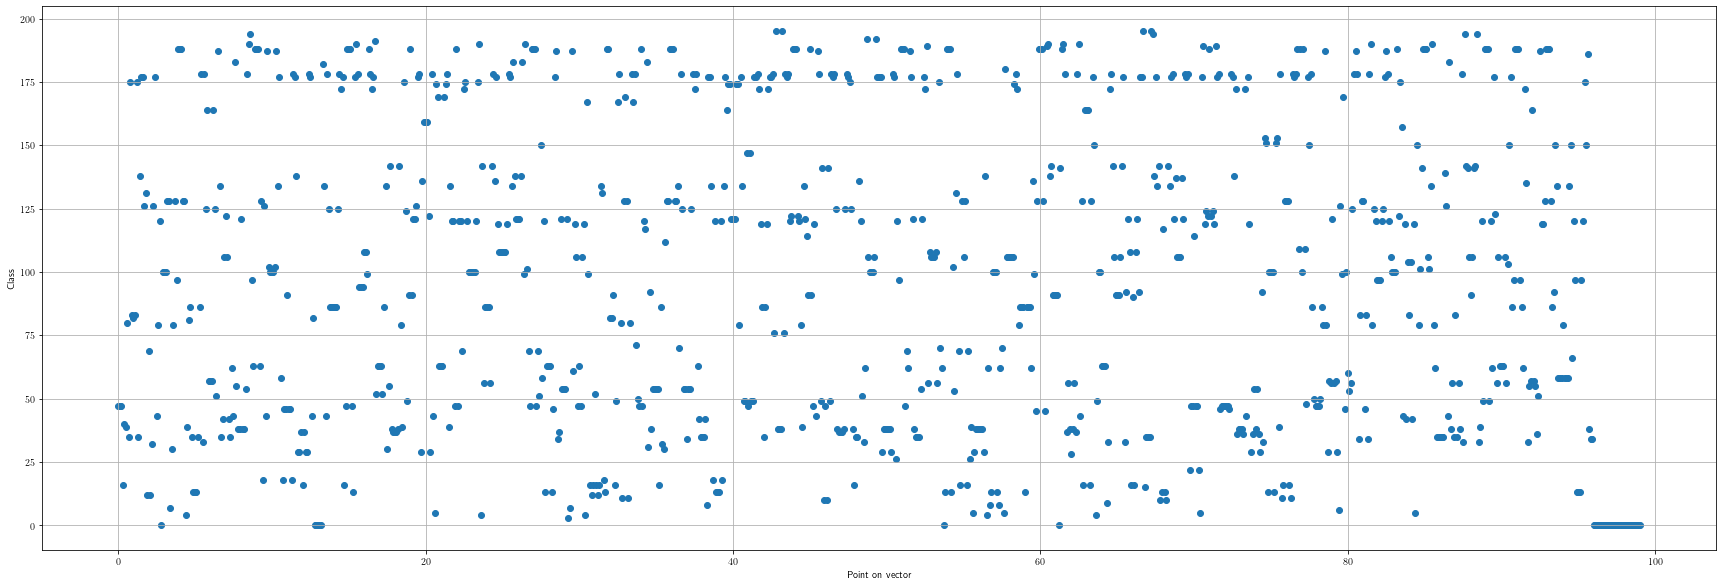

In [12]:
fig, ax = plt.subplots(1,1,figsize=(30,10))
fig.set_facecolor('white')

ax.scatter(res_x, linwalk)
ax.set_ylabel('Class')
ax.set_xlabel('Point on vector')
ax.grid()

This suggests that the generator can only generate a subset of beetle classes. 

The high end of this "spectrum" (95+) seems to all classify as class 0. This is very odd.

# compare walk of resnet34 and resnet 18

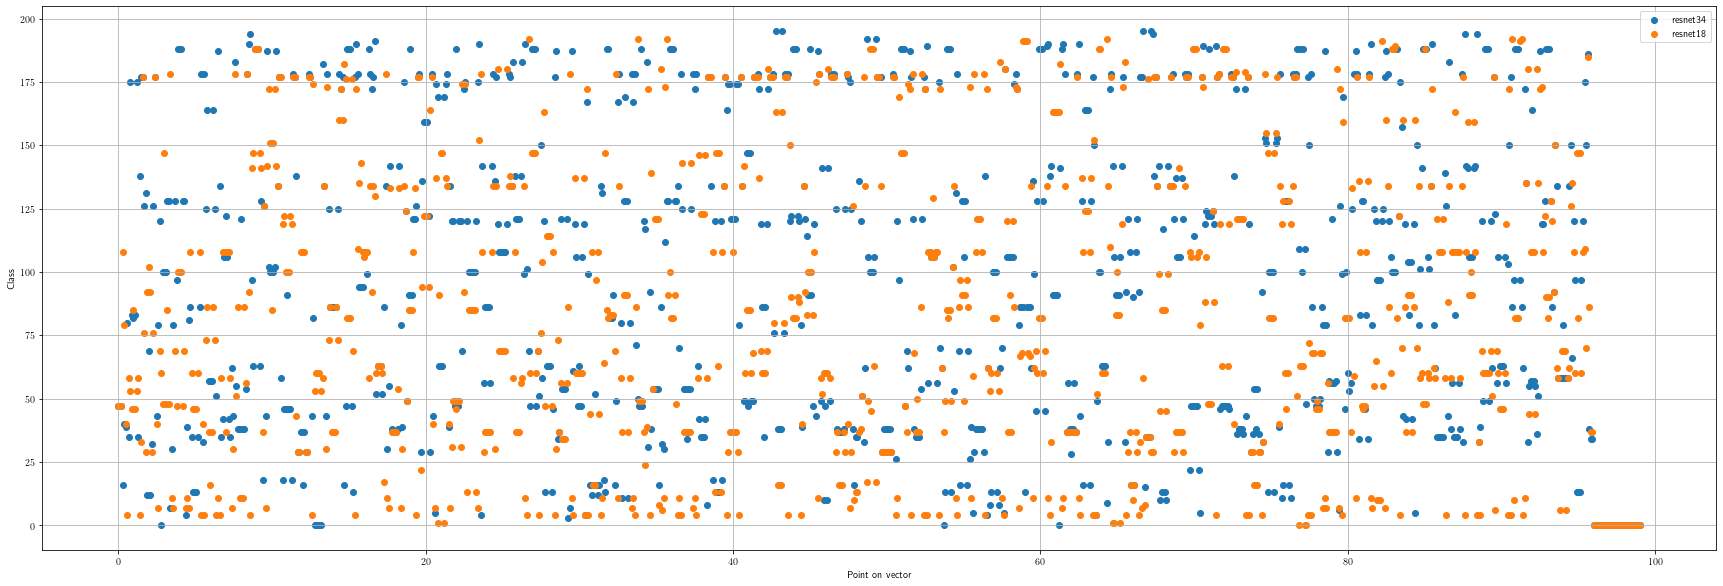

In [13]:
fig, ax = plt.subplots(1,1,figsize=(30,10))
fig.set_facecolor('white')

ax.scatter(res_x, linwalk, label='resnet34')
ax.scatter(res_x, linwalk_18, label='resnet18')
ax.set_ylabel('Class')
ax.set_xlabel('Point on vector')
ax.grid()
ax.legend()

The two models think the images should be classified differently

### Lets compare the number of each class that the models see

In [14]:
class_count_gen = np.bincount(linwalk.astype(np.int64), minlength=197)
class_count_gen_18 = np.bincount(linwalk_18.astype(np.int64), minlength=197)

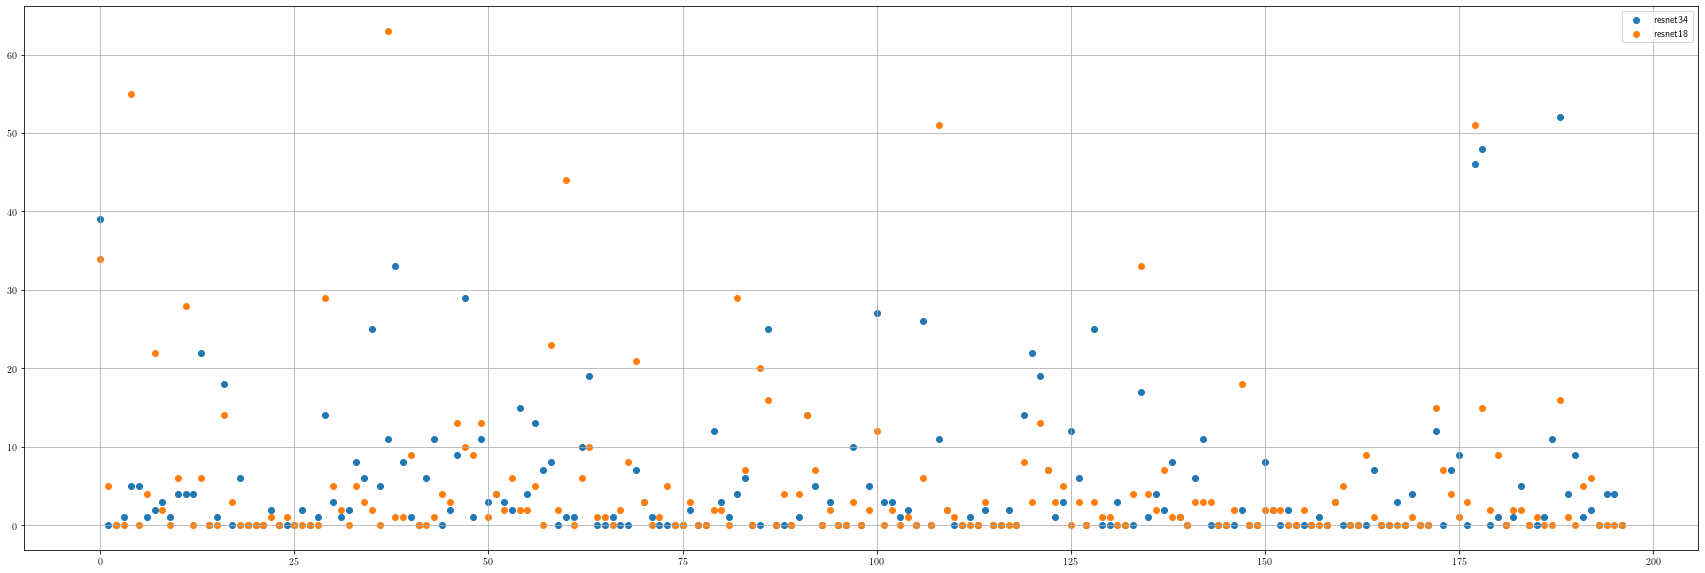

In [15]:
fig, ax = plt.subplots(1,1,figsize=(30,10))
fig.set_facecolor('white')

xs = np.linspace(0,196,197)

ax.scatter(xs, class_count_gen,label='resnet34')
ax.scatter(xs, class_count_gen_18,label='resnet18')
ax.grid()
ax.legend()

### Lets see if the distribution has something to do with the number of files for each class

In [16]:
path = './data/beetles/images/'

class_count_files = np.zeros(197)

folders = list(os.listdir(path))
folders.sort()

for i in range(len(folders)):
    class_count_files[i] = len(os.listdir(path+folders[i]))


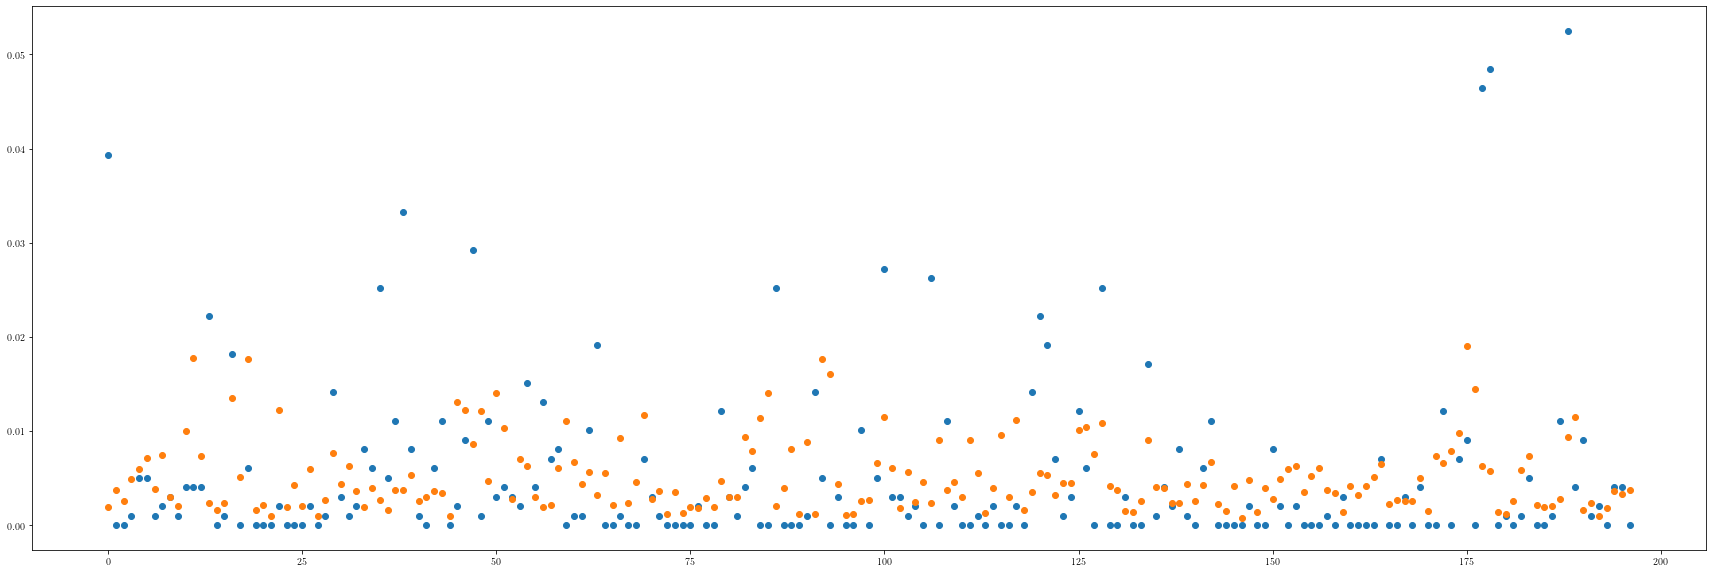

In [17]:
fig, ax = plt.subplots(1,1,figsize=(30,10))
fig.set_facecolor('white')

xs = np.linspace(0,196,197)

ax.scatter(xs, class_count_gen/np.sum(class_count_gen))
ax.scatter(xs, class_count_files/np.sum(class_count_files))

It does not look like it is overrepresentation. 

# Lets try walking along each axis

In [18]:
class_samples = np.load('./output/GANs/classes.npy')
class_samples = np.bincount(class_samples.astype(np.int64))
class_samples_prob = class_samples/np.sum(class_samples)

In [19]:
mapwalk_x = gen_input_map(1,100,100)

torch.Size([10000, 100])
torch.Size([100])


In [20]:
mapwalk = walk(mapwalk_x, gen, model, batch_size)

0 of 312
100 of 312
200 of 312
300 of 312


In [21]:
map_img = mapwalk.reshape(100, 100)

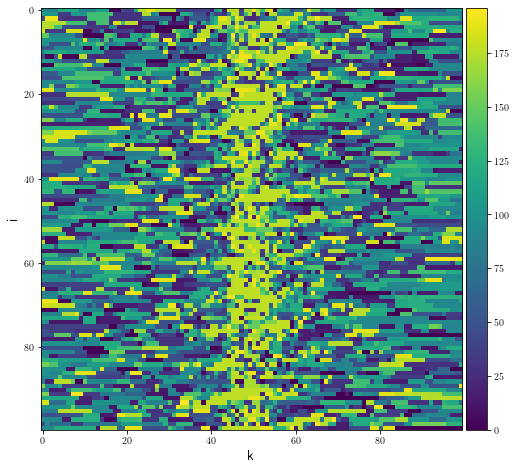

In [22]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path
fig,ax = plt.subplots(1,1,figsize=(8,8))
fig.set_facecolor('white')

mappable = ax.imshow(map_img)

ax.set_xlabel('k', size = 14)
ax.set_ylabel('i', size = 14)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(mappable, cax=cax)
Path('output/gan_generator_testing').mkdir(parents = True, exist_ok= True)
plt.savefig('output/gan_generator_testing/latent_space_map',
            dpi=200, bbox_inches='tight')

Not sure what to make of this

In [23]:
map_classes = np.bincount(map_img.reshape(-1).astype(np.int64))

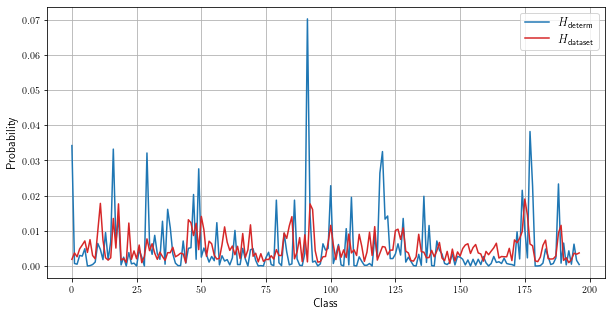

In [24]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
fig.set_facecolor('white')
ax.plot(map_classes/np.sum(map_classes), label=r'$H_\text{determ}$')
ax.plot(class_samples_prob, label=r'$H_\text{dataset}$', c = 'tab:red')
ax.set_xlabel('Class', size = 12)
ax.set_ylabel('Probability', size = 12)
ax.legend(loc='best', prop={'size': 12})
ax.grid()
plt.savefig('output/gan_generator_testing/latent_space_map_distribution',
            dpi=200, bbox_inches='tight')


# Random walk


lets generate a random input and count the classes to see how they are represented in the generator

In [25]:
randwalk_x = torch.normal(0,1,(100000,100,1,1))

In [26]:
randwalk = walk(randwalk_x, gen, model, batch_size)

0 of 3125
100 of 3125
200 of 3125
300 of 3125
400 of 3125
500 of 3125
600 of 3125
700 of 3125
800 of 3125
900 of 3125
1000 of 3125
1100 of 3125
1200 of 3125
1300 of 3125
1400 of 3125
1500 of 3125
1600 of 3125
1700 of 3125
1800 of 3125
1900 of 3125
2000 of 3125
2100 of 3125
2200 of 3125
2300 of 3125
2400 of 3125
2500 of 3125
2600 of 3125
2700 of 3125
2800 of 3125
2900 of 3125
3000 of 3125
3100 of 3125


In [27]:
rand_classes = np.bincount(randwalk.astype(np.int64))

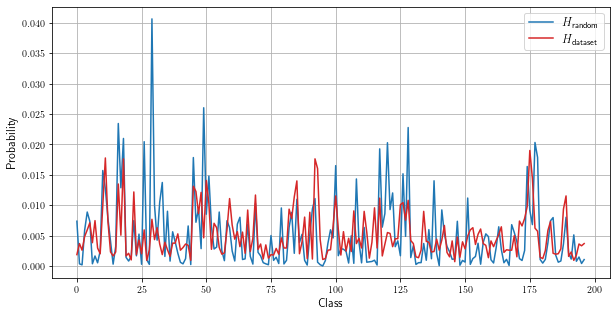

In [33]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
fig.set_facecolor('white')
ax.set_xlabel('Class', size = 12)
ax.set_ylabel('Probability', size=12)

ax.plot(rand_classes/np.sum(rand_classes), label=r'$H_\text{random}$')
ax.plot(class_samples_prob, label=r'$H_\text{dataset}$', c='tab:red')
ax.grid()
ax.legend(loc='best', prop={'size': 12})
plt.savefig('output/gan_generator_testing/random_walk_distribution',
            dpi=200, bbox_inches='tight')


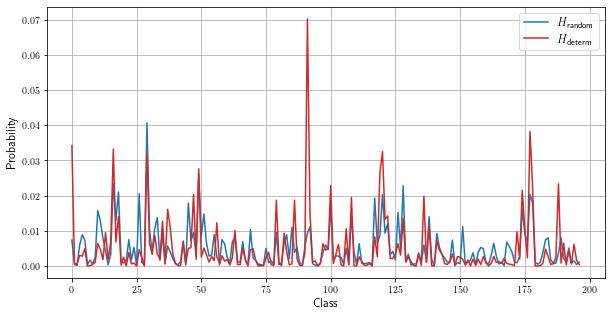

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
fig.set_facecolor('white')
ax.set_xlabel('Class', size=12)
ax.set_ylabel('Probability', size=12)

ax.plot(rand_classes/np.sum(rand_classes), label=r'$H_\text{random}$')
ax.plot(map_classes/np.sum(map_classes), label=r'$H_\text{determ}$', c = 'tab:red')
ax.grid()
ax.legend(loc='best', prop={'size': 12})
plt.savefig('output/gan_generator_testing/random_determ_distribution',
            dpi=200, bbox_inches='tight')


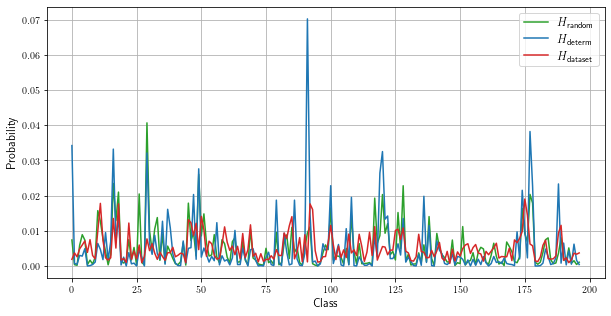

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
fig.set_facecolor('white')
ax.set_xlabel('Class', size=12)
ax.set_ylabel('Probability', size=12)

ax.plot(rand_classes/np.sum(rand_classes), label=r'$H_\text{random}$', c = 'tab:green')
ax.plot(map_classes/np.sum(map_classes),
        label=r'$H_\text{determ}$', c='tab:blue')
ax.plot(class_samples_prob, label=r'$H_\text{dataset}$', c='tab:red')
ax.grid()
ax.legend(loc='best', prop={'size': 12})
plt.savefig('output/gan_generator_testing/distribution_comparison',
            dpi=200, bbox_inches='tight')

In [29]:
import pandas as pd

In [30]:
class_nr = np.arange(197)

rand_data = np.vstack((class_nr.reshape(1,-1), rand_classes.reshape(1,-1)))
rand_df = pd.DataFrame(rand_data, index=['class', 'count'])
pd.set_option('display.max_columns', None)
rand_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196
class,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196
count,738,37,20,591,889,736,38,166,54,248,1572,1270,784,404,32,324,2345,1288,2099,143,83,159,748,169,526,30,2046,104,28,4066,999,426,1050,1375,159,902,82,564,396,212,62,37,122,660,25,1785,721,945,287,2604,853,1480,648,281,313,889,255,89,746,632,248,84,690,803,108,119,690,160,33,1030,226,167,56,37,22,502,94,146,42,956,35,95,639,883,210,1098,386,523,94,17,521,941,1110,64,23,2,90,376,597,463,1652,171,287,277,243,50,498,45,1433,393,53,635,64,70,76,97,17,1928,641,864,2029,929,1203,319,415,170,1518,489,2279,140,335,27,56,57,372,96,600,121,1403,211,7,924,525,323,235,112,118,737,14,93,66,1119,28,123,158,376,31,389,530,485,104,51,303,646,272,55,111,11,681,553,403,123,92,257,1638,916,682,2033,1788,108,49,110,384,745,798,181,64,84,363,803,214,115,513,79,149,43,107
